In [1]:
packages = !pip list
for x in packages:
    if "qiskit" in x:
        print(x)

qiskit                1.1.0
qiskit-aer            0.14.1
qiskit-ibm-provider   0.11.0
qiskit-ibm-runtime    0.24.0


In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
# from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

token = "#"


# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum",token=token)

# Invoke a primitive. For more details see https://docs.quantum.ibm.com/run/primitives
# result = Sampler().run(circuits).result()

IBMNotAuthorizedError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login with some authorized provider required., Error code: 3445.'

In [3]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile,QuantumRegister,ClassicalRegister, assemble
from qiskit.visualization import *
from qiskit_aer import QasmSimulator,Aer
from qiskit.quantum_info import random_statevector
from qiskit.circuit.library import Initialize

<IPython.core.display.Latex object>

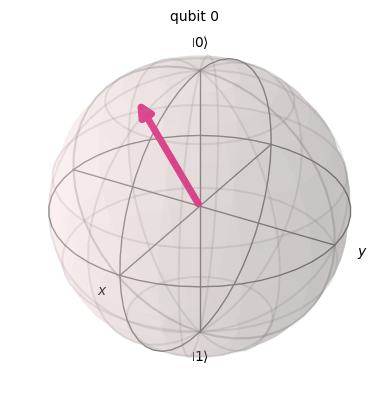

In [4]:
# Create random 1-qubit state, this will be the state to be teleported by Alice
psi = random_statevector(2)
# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

In [5]:
init_gate = Initialize(psi)
init_gate.label = "init"

#define a function to create a bell pair 1/sqrt(2)[|00>+|11>]. create_bell_pair(circuit,qubitofalice,qubitofbob)
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target
#define a function to apply HxIxI and CNOTxI by Alice on the qubits she has from the complete state |psi>|e>
#alice_gates(circuit,statetobeteleported,oneoftheentangledparticleheldbyAlice)
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)
#measurement performed by Alice
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

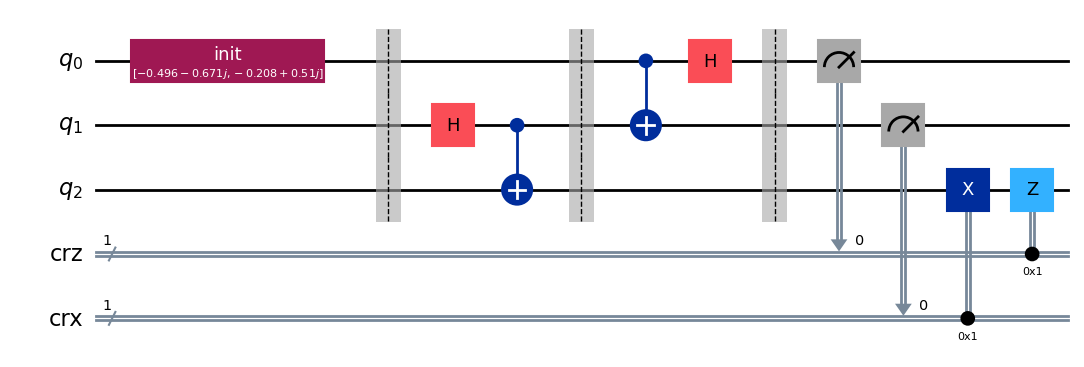

In [6]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers
    qc.z(qubit).c_if(crz, 1) # are in the state '1'
    
## SETUP
qr = QuantumRegister(3, name="q") # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)
# Display the circuit
qc.draw('mpl')

       ┌───────────────────────────────────────────┐ ░            ░      ┌───┐»
  q_0: ┤ init(-0.49612-0.67111j,-0.20793+0.51014j) ├─░────────────░───■──┤ H ├»
       └───────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘»
  q_1: ──────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├─────»
                                                     ░ └───┘┌─┴─┐ ░ └───┘     »
  q_2: ──────────────────────────────────────────────░──────┤ X ├─░───────────»
                                                     ░      └───┘ ░           »
crz: 1/═══════════════════════════════════════════════════════════════════════»
                                                                              »
crx: 1/═══════════════════════════════════════════════════════════════════════»
                                                                              »
«        ░ ┌─┐                 
«  q_0: ─░─┤M├─────────────────
«        ░ └╥┘┌─┐              
«  q_1: ─░──╫─┤M├───────

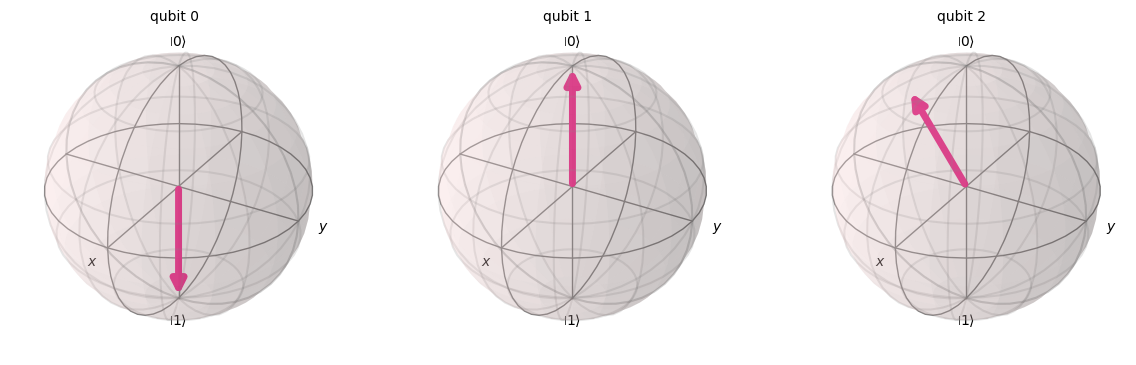

In [7]:
sim = Aer.get_backend('aer_simulator')
print(qc)
qc.save_statevector()
print(qc)
out_vector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)
#Check the blochvector of last sphere it matches with that of the initial state held by Alice

In [8]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import session
aer_sim = AerSimulator()
with Session(backend=aer_sim) as session:
    sampler = Sampler(session=session)
    result = sampler.run([qc],optimization_level=3).result()
# hist1 = plot_histogram(result.quasi_dists, sort='value_desc')
# hist1

C:\Users\NFSBM\AppData\Local\Temp\ipykernel_19484\1742588989.py:5: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session)


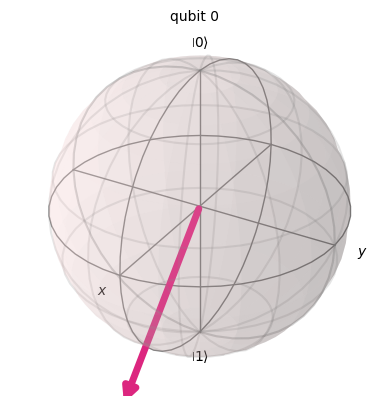

In [9]:
t=result.metadata[0]
plot_bloch_multivector(((t['simulator_metadata'])['input_qubit_map'])[0:2])


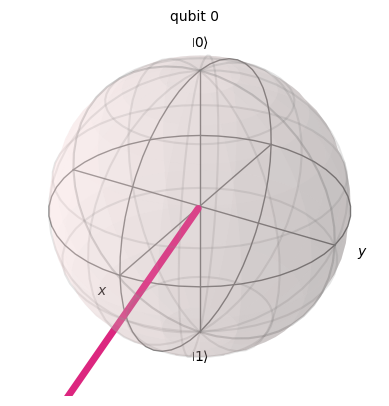

In [10]:
plot_bloch_multivector(((t['simulator_metadata'])['input_qubit_map'])[1:3])


In [11]:
t=result.metadata[0]
l=(t['simulator_metadata'])['input_qubit_map']
# plot_bloch_multivector(out_vector[l[0]:l[1]])

In [12]:
from qiskit_ibm_provider import IBMProvider
IBMProvider.save_account(token, overwrite=True)
provider = IBMProvider()
list = provider.backends()
print("backends available: ", list)


backends available:  [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibm_sherbrooke')>]


In [13]:
l = service.least_busy()
print(l.name)

ibm_osaka


In [19]:
# backend = provider.get_backend('ibm_kyoto')
backend = provider.get_backend(l.name)
out_vector = backend.run(transpile(qc)).result().get_statevector()
plot_bloch_multivector(out_vector)

IBMJobFailureError: 'Job failed: Instruction initialize on qubits (0,) from the 0-th circuit is not supported by the target. -- \\n        Transpile your circuits for the target before submitting a primitive query. For\\n        example, you can use the following code block given an IBMBackend object `backend`\\n        and circuits of type `List[QuantumCircuit]`:\\n            from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager\\n            pm = generate_preset_pass_manager(optimization_level=1, target=backend.target)\\n            isa_circuits = pm.run(circuits)\\n        Then pass `isa_circuits` to the Sampler or Estimator.\\n         -- https://ibm.biz/error_codes#1517'

In [17]:
results = job.result()#.get_statevector()
# plot_bloch_multivector(results)
# answer = results.get_counts()
# plot_histogram(answer)

IBMJobFailureError: 'Job failed: Instruction initialize on qubits (0,) from the 0-th circuit is not supported by the target. -- \\n        Transpile your circuits for the target before submitting a primitive query. For\\n        example, you can use the following code block given an IBMBackend object `backend`\\n        and circuits of type `List[QuantumCircuit]`:\\n            from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager\\n            pm = generate_preset_pass_manager(optimization_level=1, target=backend.target)\\n            isa_circuits = pm.run(circuits)\\n        Then pass `isa_circuits` to the Sampler or Estimator.\\n         -- https://ibm.biz/error_codes#1517'